# 🧠 Clasificador de Estado de Salud con PyTorch

Este proyecto utiliza una red neuronal profunda (MLP) implementada en PyTorch para clasificar el estado de salud de pacientes en tres categorías: **mala**, **regular** o **buena**, usando un conjunto de datos tabulares.

---


## Importar librerias

In [28]:
# Manejo de datos
import numpy as np
import pandas as pd
import random
import os

# Modelos de Deep Learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#Preprocesamiento de datos
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Gráficos
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Configuración warnings (Quitar en caso de errores desconocidos)
import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE

# Versión de paquetes usados
color = '\033[1m\033[38;5;208m'
print(f"{color}Versión de las librerias utilizadas:")
print(f"{color}- Version torch: {torch.__version__}")
print(f"{color}- Version pandas: {pd.__version__}")
print(f"{color}- Version numpy: {np.__version__}")
print(f"{color}- Version sklearn: {pd.__version__}")

Versión de las librerias utilizadas:
- Version torch: 2.7.1+cpu
- Version pandas: 2.2.3
- Version numpy: 2.2.6
- Version sklearn: 2.2.3


## Lectura del dataset

In [31]:
try:
    # 1. Cargar el nuevo dataset multiclase
    data_test = pd.read_csv('Datasets/datasetMulti.csv')
    data = pd.read_csv('Datasets/generated_data_gan_pytorch_1_2.csv')
    print("Archivo cargado correctamente.")
except Exception as e:
    print(f"Error: {e}")

Archivo cargado correctamente.


In [32]:
data_test = data_test.drop(columns=['ID', 'No_Pation'])
data_test['CLASS'] = data_test['CLASS'].astype(str).str.strip()
data_test['Gender'] = data_test['Gender'].astype(str).str.strip().str.upper()
# Mapear valores de 'Gender' a numéricos y luego aplicar One-Hot Encoding si es necesario
# Para 'Gender', puedes mapear 'F' a 0 y 'M' a 1.
data_test['Gender'] = data_test['Gender'].map({'F': 0, 'M': 1})
data['Gender'] = data['Gender'].map({'F': 0, 'M': 1})

# Mapear 'CLASS' (ahora 'CLASS') a valores numéricos si no lo están ya
# 'N'=0, 'P'=1, 'Y'=2
class_mapping = {'N': 0, 'P': 1, 'Y': 2}
data_test['CLASS'] = data_test['CLASS'].map(class_mapping)
data['CLASS'] = data['CLASS'].map(class_mapping)

print("Preprocesamiento listo. Nuevas columnas:")
print(data.columns)
data.head()
print(data_test.columns)
data_test.head()

Preprocesamiento listo. Nuevas columnas:
Index(['Gender', 'AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL',
       'VLDL', 'BMI', 'CLASS'],
      dtype='object')
Index(['Gender', 'AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL',
       'VLDL', 'BMI', 'CLASS'],
      dtype='object')


,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,0,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,0
1,1,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,0
2,0,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,0
3,0,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,0
4,1,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,0


In [33]:
seed = 110425
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


In [34]:
print("--- Distribución de clases en el dataset completo (antes de SMOTE) ---")
print(data['CLASS'].value_counts())
print("-" * 50)

# 2. Separar características (x) y objetivo (y)
X_train = data.drop(columns=["CLASS"]).to_numpy()
y_train = data["CLASS"].to_numpy()
X_test = data_test.drop(columns=["CLASS"]).to_numpy()
y_test = data_test["CLASS"].to_numpy()

# 3. Dividir en conjuntos de entrenamiento, validación y prueba ANTES de SMOTE
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42, stratify=y_train) # 15% del resto para validación

# 4. Aplicar el escalado
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val) # Usar el mismo scaler del train
X_test = scaler.transform(X_test) # Usar el mismo scaler del train


--- Distribución de clases en el dataset completo (antes de SMOTE) ---
CLASS
1    50000
0    50000
2    50000
Name: count, dtype: int64
--------------------------------------------------


In [35]:
#Train
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

#Val
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

#Test
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [36]:
batchsize = 32
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_data = DiabetesDataset(X_train, y_train)
val_data = DiabetesDataset(X_val, y_val)
test_data = DiabetesDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batchsize, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batchsize, shuffle=False)

In [10]:
len(train_data)

1713

In [44]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hc1 = nn.Linear(11, 256) # Ajuste automático al número de columnas
        self.hc2 = nn.Linear(256, 128)
        self.hc3 = nn.Linear(128, 64)
        # 4. Ajustar la capa de salida a 3 neuronas para la clasificación multiclase
        self.hc4 = nn.Linear(64, 3) 
        self.act = nn.LeakyReLU()
        self.dp1 = nn.Dropout(0.4)
        self.dp2 = nn.Dropout(0.2)

    def forward(self, input):
        l1 = self.dp1(self.act(self.hc1(input)))
        l2 = self.dp2(self.act(self.hc2(l1)))
        l3 = self.act(self.hc3(l2))
        output = self.hc4(l3)
        return output

In [45]:
testeo = MLP()
lr = 1e-4
opt = torch.optim.Adam(testeo.parameters(), lr=lr, weight_decay=1e-4)
# lr = 1e-4
# opt = torch.optim.SGD(testeo.parameters(), lr=lr, weight_decay=1e-4)
loss_func = nn.CrossEntropyLoss()


In [13]:
lambda_l1 = 1e-3
def l1_penalty(model):
    l1 = 0.0
    for param in model.parameters():
        if param.requires_grad and len(param.shape) > 1:
            l1 += torch.norm(param, p=1)
    return l1

In [46]:
#Entrenamiento

n_epochs = 2000
history = {
    "TL" : [],
    "VL" : []
}
early_stopping = {
    "delta" : 1e-5,
    "patience": 10
}
best_val_loss = float("inf")
aux = 0

for i in range(n_epochs+1):
    testeo.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:  
      output = testeo(X_batch)
      loss = loss_func(output, y_batch)  #+ l1_penalty(testeo) *lambda_l1
      
      opt.zero_grad()
      loss.backward()
      opt.step()

      epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    history["TL"].append(epoch_loss)

    testeo.eval()
    epoch_loss = 0
    for X_batch, y_batch in val_loader:
      with torch.no_grad():
        preds_val = testeo(X_batch)
      val_loss = loss_func(preds_val, y_batch)

      epoch_loss += val_loss.item()
    epoch_loss /= len(val_loader)
    history["VL"].append(epoch_loss)
    
    if epoch_loss + early_stopping["delta"] < best_val_loss:
      best_val_loss = epoch_loss
      aux = 0
      print(f"Reinicio aux en epoch {i}")
    else:
      aux += 1
      if aux >= early_stopping["patience"]:
        print(f"Terminando el entrenamiento en la época {i}")
        break
    

Reinicio aux en epoch 0
Reinicio aux en epoch 1
Reinicio aux en epoch 2
Reinicio aux en epoch 3
Reinicio aux en epoch 4
Reinicio aux en epoch 5
Reinicio aux en epoch 6
Reinicio aux en epoch 7
Reinicio aux en epoch 10
Reinicio aux en epoch 11
Reinicio aux en epoch 17
Reinicio aux en epoch 18
Reinicio aux en epoch 19
Reinicio aux en epoch 25
Reinicio aux en epoch 26
Reinicio aux en epoch 32
Reinicio aux en epoch 36
Reinicio aux en epoch 39
Terminando el entrenamiento en la época 49


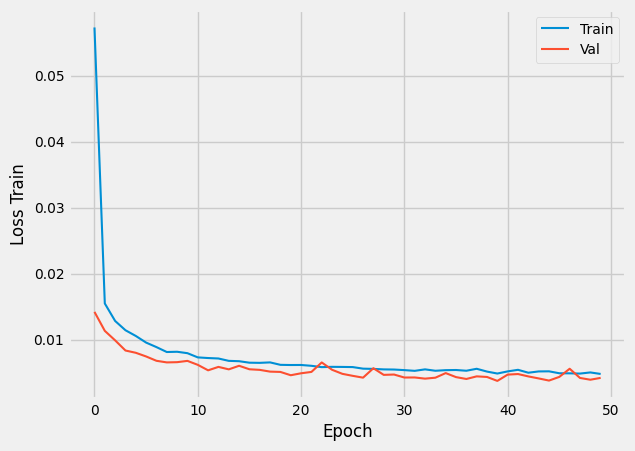

In [47]:

plt.plot(history["TL"], label="Train")
plt.plot(history["VL"], label="Val")
plt.xlabel('Epoch')
plt.ylabel('Loss Train')
plt.legend()
plt.show()

In [48]:
#Train
with torch.no_grad():
    output_train = testeo(X_train)
y_hat_train = output_train.numpy()
y_hat_train = [np.argmax(i) for i in y_hat_train]
print(f'Training Accuracy: {accuracy_score(y_train, y_hat_train):.2f}')
#Testeo
with torch.no_grad():
    output = testeo(X_test)  
y_hat = output.numpy()
y_hat = [np.argmax(i) for i in y_hat]
print(f'Testing Accuracy: {accuracy_score(y_test, y_hat):.2f}')

Training Accuracy: 1.00
Testing Accuracy: 0.81


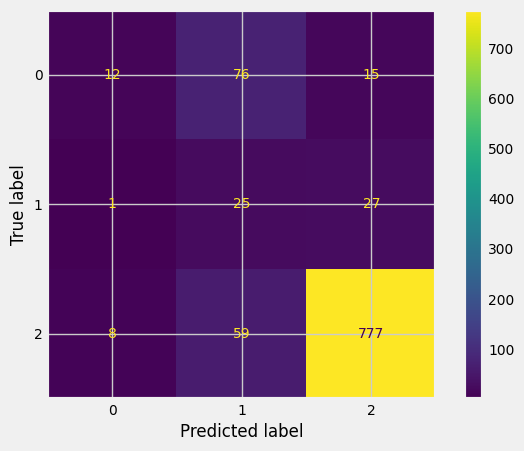

In [49]:
cm =confusion_matrix(y_test, y_hat)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_plot.plot()
plt.show()